In [ ]:
import time
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_measurement(index, true_x, true_y):
    """
    Simulate an expensive operation to compute the measurement at 'index'.
    For demonstration, we just return the CSV value, but we also add a 1-2s delay
    to mimic a heavy calculation (e.g., image processing).
    """
    time.sleep(random.uniform(0.1, 0.2))  # expensive computation
    return np.array([true_x[index], true_y[index]], dtype=float)

def event_triggered_kalman_filter_with_outlier_gating(
    csv_path,
    diff_threshold=0.5,       # trigger if predicted differs from last used measurement by > 0.5
    uncertainty_threshold=0.3,# trigger if sqrt of covariance diag in x or y exceeds 0.3
    process_noise=0.001,      # Q diagonal for random walk (x, y)
    measurement_noise=0.1,    # R diagonal for measurement (x, y)
    gating_threshold=5.0      # Mahalanobis gating threshold
):
    """
    Demonstrates an Event-Triggered Kalman Filter (ETKF) with outlier gating,
    where we ONLY perform the expensive measurement (center calculation) when triggered.

    Returns a DataFrame with columns:
        frame_number, meas_x, meas_y, est_x, est_y, triggered_update, used_measurement, err_x, err_y
    """
    # 1) Load CSV data so we can compare with ground truth (optional for a real system).
    df = pd.read_csv(csv_path).sort_values('frame_number').reset_index(drop=True)
    frames = df['frame_number'].values
    true_x_all = df['center_x'].values
    true_y_all = df['center_y'].values
    n_frames = len(df)
    
    # 2) Setup Kalman filter for a 2D random walk
    F = np.eye(2)             # state transition (x->x, y->y)
    H = np.eye(2)             # measurement matrix
    Q = process_noise * np.eye(2)
    R = measurement_noise * np.eye(2)

    # Initialize at the first known position (just for demonstration).
    # If you truly don’t know the first measurement, you can set this arbitrarily.
    x_est = np.array([true_x_all[0], true_y_all[0]], dtype=float)
    P_est = 0.01 * np.eye(2)
    
    # 'last_meas' holds the last measurement we actually used (not the prediction)
    last_meas = x_est.copy()

    output_records = []
    columns = [
        'frame_number',
        'meas_x',
        'meas_y',
        'est_x',
        'est_y',
        'triggered_update',
        'used_measurement',
        'err_x',
        'err_y'
    ]

    start_time = time.time()
    last_plot_time = start_time

    # 3) Main loop over frames, with a progress bar
    for i in tqdm(range(n_frames), desc="Processing frames"):
        frame_i = frames[i]

        # Predict step (no measurement used yet)
        x_pred = F @ x_est
        P_pred = F @ P_est @ F.T + Q
        
        # Decide if we need to get a new measurement
        diff_from_last_meas = np.linalg.norm(x_pred - last_meas)
        std_dev_pred = np.sqrt(np.diag(P_pred))
        
        # We'll mark these as defaults, then update if triggered
        triggered_update = False
        used_measurement = False
        meas_x, meas_y = (np.nan, np.nan)

        # If the predicted position is far from the last measurement, or if the uncertainty is large,
        # then we "trigger" a new measurement.
        if (diff_from_last_meas > diff_threshold) or (std_dev_pred > uncertainty_threshold).any():
            triggered_update = True

            # 3A) Fetch (i.e., "compute") measurement only if triggered
            z_true = get_measurement(i, true_x_all, true_y_all)

            # 3B) Outlier gating using Mahalanobis distance
            S = P_pred + R  # H = I, so S = P_pred + R
            y_residual = z_true - x_pred
            try:
                dist = y_residual @ np.linalg.inv(S) @ y_residual
            except np.linalg.LinAlgError:
                dist = np.inf  # If numerical issues, treat as outlier

            if dist <= gating_threshold:
                # Accept the measurement
                used_measurement = True
                meas_x, meas_y = z_true[0], z_true[1]

                # Kalman gain and update
                K = P_pred @ np.linalg.inv(S)
                x_est = x_pred + K @ y_residual
                P_est = (np.eye(2) - K) @ P_pred
                last_meas = z_true.copy()
            else:
                # Outlier, skip update
                x_est = x_pred
                P_est = P_pred
        else:
            # Not triggered, so no measurement
            x_est = x_pred
            P_est = P_pred

        # For demonstration, we compare estimate to 'true' CSV coordinate
        # (In a real system, you typically wouldn't know the "true_x_all[i]" unless you measure.)
        true_x_i = true_x_all[i]
        true_y_i = true_y_all[i]
        err_x = x_est[0] - true_x_i
        err_y = x_est[1] - true_y_i

        output_records.append((
            frame_i,
            meas_x,
            meas_y,
            x_est[0],
            x_est[1],
            triggered_update,
            used_measurement,
            err_x,
            err_y
        ))

        # 4) Periodically plot partial progress every 10 seconds of real time
        current_time = time.time()
        if (current_time - last_plot_time) >= 10.0:
            last_plot_time = current_time
            partial_df = pd.DataFrame(output_records, columns=columns)

            # We'll reconstruct the "actual" center for partial_df
            # actual_x = est_x - err_x
            # actual_y = est_y - err_y
            # But for clarity, let's just read them from original CSV since we have them.
            # (If you truly didn't want to store them, you'd skip real-time plotting of the "actual.")
            partial_true_x = []
            partial_true_y = []
            for row_idx in partial_df.index:
                fnum = partial_df.loc[row_idx, 'frame_number']
                # match that frame number in DF (or we could have stored them in arrays by index)
                # but since we used i in order, this is easy:
                partial_true_x.append(true_x_all[fnum])
                partial_true_y.append(true_y_all[fnum])

            plt.figure()
            plt.plot(partial_df['frame_number'], partial_true_x,
                     label='Actual X', linestyle='--', alpha=0.3)
            plt.plot(partial_df['frame_number'], partial_df['est_x'],
                     label='Estimated X', linestyle='-')
            plt.scatter(partial_df['frame_number'], partial_df['meas_x'],
                        label='Used Meas X', s=10)
            plt.title("Partial Progress: Center X")
            plt.xlabel("Frame Number")
            plt.ylabel("X Position")

            # Adjust y-axis: calculate min, max of estimated Y and add 10% margin.
            min_est_x = partial_df['est_x'].min()
            max_est_x = partial_df['est_x'].max()
            margin_x = (max_est_x - min_est_x) * 2
            plt.ylim(min_est_x - margin_x, max_est_x + margin_x)

            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(partial_df['frame_number'], partial_true_y,
                     label='Actual Y', linestyle='--', alpha=0.3)
            plt.plot(partial_df['frame_number'], partial_df['est_y'],
                     label='Estimated Y', linestyle='-')
            plt.scatter(partial_df['frame_number'], partial_df['meas_y'],
                        label='Used Meas Y', s=10)
            plt.title("Partial Progress: Center Y")
            plt.xlabel("Frame Number")
            plt.ylabel("Y Position")


            # Adjust y-axis: calculate min, max of estimated Y and add 10% margin.
            min_est_y = partial_df['est_y'].min()
            max_est_y = partial_df['est_y'].max()
            margin_y = (max_est_y - min_est_y) * 2
            plt.ylim(min_est_y - margin_y, max_est_y + margin_y)

            plt.legend()
            plt.show()

    # 5) Final results
    out_df = pd.DataFrame(output_records, columns=columns)
    print(f"\nETKF complete. Used {out_df['used_measurement'].sum()} measurements out of {n_frames} frames.\n")
    return out_df

# ==================== USAGE EXAMPLE ====================
csv_path = "/Users/xiaodong/Desktop/UOX-data/UOX1/ICFuox1min15p.csv"

out = event_triggered_kalman_filter_with_outlier_gating(
    csv_path,
    diff_threshold=1,
    uncertainty_threshold=1.0,
    process_noise=0.05,
    measurement_noise=1.0,
    gating_threshold=0.5
)

# ================ Final Plot (After All Frames) ================
if out is not None and len(out) > 0:
    df = out.copy()
    # For demonstration, retrieve the "true" positions from CSV so we can compare final results:
    # (Again, in a real system, you likely wouldn't have them all unless you measure them.)
    original = pd.read_csv(csv_path).sort_values('frame_number').reset_index(drop=True)
    
    # Merge 'out' with original so we can easily get the actual center
    merged = pd.merge(df, original[['frame_number','center_x','center_y']], on='frame_number', how='left')
    
    plt.figure()
    plt.plot(merged['frame_number'], merged['center_x'], label='Actual X', linestyle='--', alpha=0.3)
    plt.plot(merged['frame_number'], merged['est_x'], label='Estimated X', linestyle='-')
    plt.scatter(merged['frame_number'], merged['meas_x'], label='Used Meas X', s=10)
    plt.title("Final: Actual vs Estimated X")
    plt.xlabel("Frame Number")
    plt.ylabel("X Position")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(merged['frame_number'], merged['center_y'], label='Actual Y', linestyle='--', alpha=0.3)
    plt.plot(merged['frame_number'], merged['est_y'], label='Estimated Y', linestyle='-')
    plt.scatter(merged['frame_number'], merged['meas_y'], label='Used Meas Y', s=10)
    plt.title("Final: Actual vs Estimated Y")
    plt.xlabel("Frame Number")
    plt.ylabel("Y Position")
    plt.legend()
    plt.show()


Processing frames:  39%|███▉      | 2447/6280 [00:09<00:30, 126.63it/s]

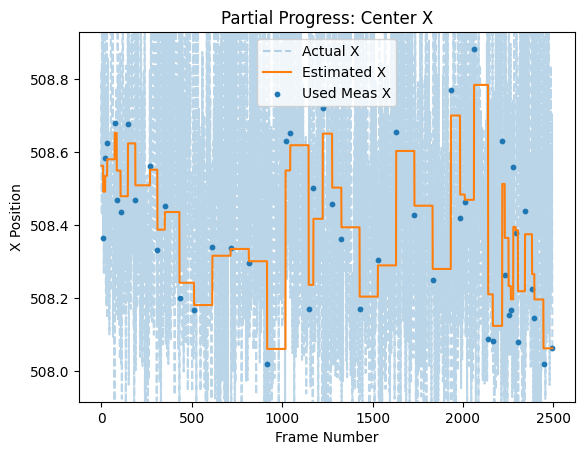

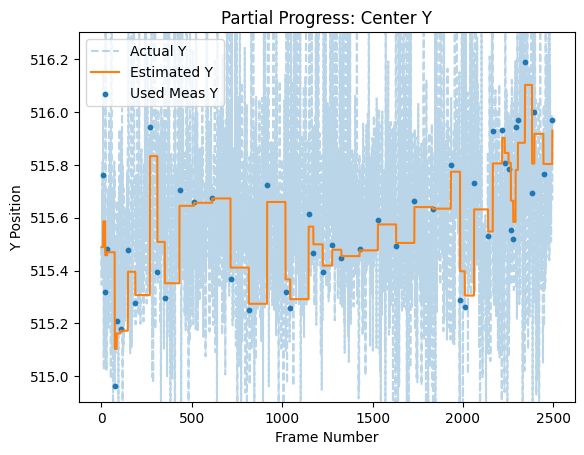

Processing frames:  83%|████████▎ | 5231/6280 [00:20<00:07, 141.34it/s]

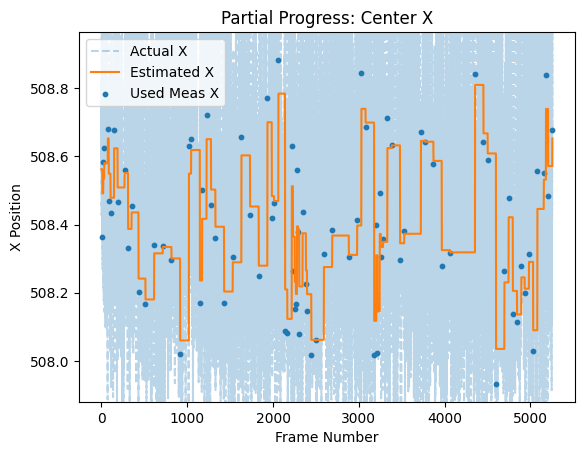

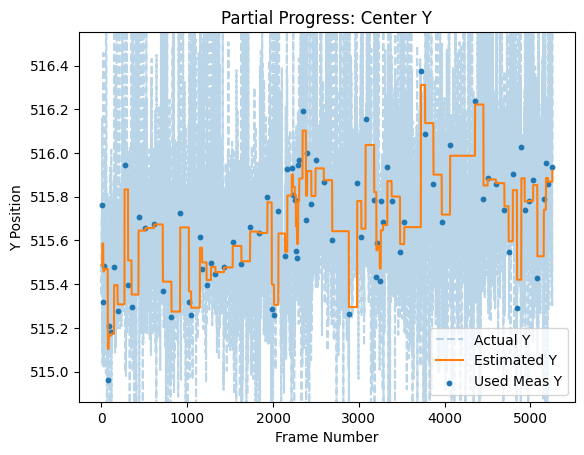

Processing frames: 100%|██████████| 6280/6280 [00:26<00:00, 237.96it/s]



Adaptive KF complete. Measurements used: 108 of 6280 frames.
Final sampling interval was 48.


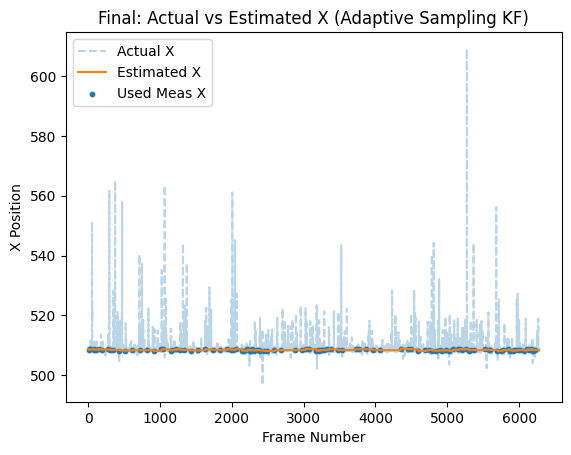

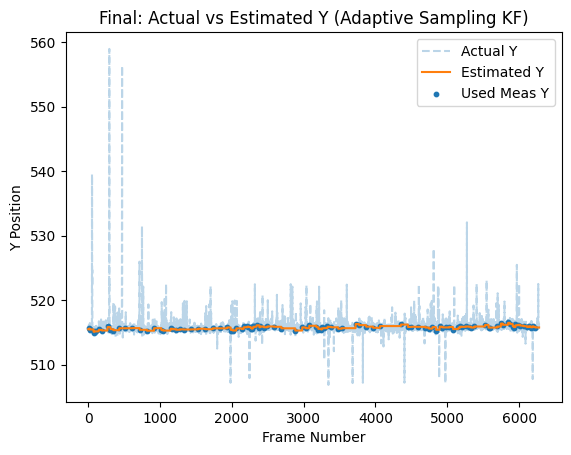

In [2]:
import time
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_measurement(index, true_x, true_y):
    """
    Simulate an expensive operation to compute the measurement at 'index'.
    For demonstration, we just return the CSV value, but we also add a short delay
    to mimic a heavy calculation (e.g., image processing).
    """
    time.sleep(random.uniform(0.1, 0.2))  # "expensive" computation
    return np.array([true_x[index], true_y[index]], dtype=float)

def adaptive_sampling_kalman_filter(
    csv_path,
    process_noise=0.001,      # Q diagonal for random walk (x, y)
    measurement_noise=0.1,    # R diagonal for measurement (x, y)
    gating_threshold=5.0,     # Mahalanobis gating threshold
    initial_interval=5,       # Start by measuring every 5 frames
    error_threshold=1.0,      # If error > this, we reduce interval
    min_interval=1,           # Lowest sampling interval
    max_interval=50           # Highest sampling interval
):
    """
    Demonstrates a Kalman Filter with:
      - Adaptive sampling interval based on an error metric.
      - Outlier gating to reject bad measurements.

    Algorithm outline:
      1) Start with 'sampling_interval = initial_interval' (e.g., measure every 5 frames).
      2) Each time we sample, compute measurement error vs. predicted state.
      3) If error is too large, measure more frequently (reduce interval).
      4) If error is very small, measure less frequently (increase interval).
      5) Outlier gating is applied if a measurement is taken.

    Returns a DataFrame with columns:
        frame_number, meas_x, meas_y, est_x, est_y, took_measurement, used_measurement, err_x, err_y
    """
    # --- 1) Load data (for demonstration we do have ground truth) ---
    df = pd.read_csv(csv_path).sort_values('frame_number').reset_index(drop=True)
    frames = df['frame_number'].values
    true_x_all = df['center_x'].values
    true_y_all = df['center_y'].values
    n_frames = len(df)

    # --- 2) Setup Kalman filter for a 2D random walk ---
    F = np.eye(2)  # state transition
    H = np.eye(2)  # measurement matrix
    Q = process_noise * np.eye(2)
    R = measurement_noise * np.eye(2)

    # Initialize the state with the first frame (for demonstration).
    x_est = np.array([true_x_all[0], true_y_all[0]], dtype=float)
    P_est = 0.01 * np.eye(2)

    # Keep track of last measurement used
    last_meas = x_est.copy()

    # Adaptive sampling parameters
    sampling_interval = initial_interval
    frames_since_last_measurement = 0

    output_records = []
    columns = [
        'frame_number',
        'meas_x',
        'meas_y',
        'est_x',
        'est_y',
        'took_measurement',   # did we attempt to measure this frame?
        'used_measurement',   # outlier gating accepted the measurement?
        'err_x',
        'err_y'
    ]

    start_time = time.time()
    last_plot_time = start_time

    # --- 3) Main loop over frames ---
    for i in tqdm(range(n_frames), desc="Processing frames"):
        frame_i = frames[i]

        # -- Predict step --
        x_pred = F @ x_est
        P_pred = F @ P_est @ F.T + Q

        took_measurement = False
        used_measurement = False
        meas_x, meas_y = (np.nan, np.nan)

        # Decide if it's time to measure
        if frames_since_last_measurement >= sampling_interval:
            took_measurement = True
            # "Compute" the measurement (expensive step)
            z_true = get_measurement(i, true_x_all, true_y_all)

            # Outlier gating (Mahalanobis)
            S = P_pred + R  # since H=I
            y_residual = z_true - x_pred
            try:
                dist = y_residual @ np.linalg.inv(S) @ y_residual
            except np.linalg.LinAlgError:
                dist = np.inf

            if dist <= gating_threshold:
                # Accept the measurement
                used_measurement = True
                meas_x, meas_y = z_true[0], z_true[1]

                # Update (Kalman)
                K = P_pred @ np.linalg.inv(S)
                x_est = x_pred + K @ y_residual
                P_est = (np.eye(2) - K) @ P_pred

                # Compute error magnitude
                error_mag = np.linalg.norm(z_true - x_pred)

                # Adaptive interval logic:
                # If error is large, reduce interval; if error is very small, increase
                if error_mag > error_threshold:
                    # reduce sampling interval (more frequent)
                    sampling_interval = max(min_interval, sampling_interval // 2)
                elif error_mag < (error_threshold / 2.0):
                    # increase sampling interval (less frequent)
                    sampling_interval = min(max_interval, sampling_interval * 2)

                # Update last meas
                last_meas = z_true.copy()

            else:
                # Outlier: skip update
                x_est = x_pred
                P_est = P_pred

            # Reset the counter since we took a measurement (even if it was outlier)
            frames_since_last_measurement = 0

        else:
            # No measurement this frame, proceed with predict
            x_est = x_pred
            P_est = P_pred
            frames_since_last_measurement += 1

        # Evaluate error wrt known ground truth (for demonstration)
        true_x_i = true_x_all[i]
        true_y_i = true_y_all[i]
        err_x = x_est[0] - true_x_i
        err_y = x_est[1] - true_y_i

        # Record this frame's data
        output_records.append((
            frame_i,
            meas_x,
            meas_y,
            x_est[0],
            x_est[1],
            took_measurement,
            used_measurement,
            err_x,
            err_y
        ))

        # -- Periodically plot partial results every 10 seconds --
        current_time = time.time()
        if (current_time - last_plot_time) >= 10.0:
            last_plot_time = current_time
            partial_df = pd.DataFrame(output_records, columns=columns)

            # Reconstruct "actual" from CSV for partial plots
            partial_true_x = []
            partial_true_y = []
            for row_idx in partial_df.index:
                fnum = partial_df.loc[row_idx, 'frame_number']
                partial_true_x.append(true_x_all[fnum])
                partial_true_y.append(true_y_all[fnum])

            # Plot X
            plt.figure()
            plt.plot(partial_df['frame_number'], partial_true_x,
                     label='Actual X', linestyle='--', alpha=0.3)
            plt.plot(partial_df['frame_number'], partial_df['est_x'],
                     label='Estimated X', linestyle='-')
            plt.scatter(partial_df['frame_number'], partial_df['meas_x'],
                        label='Used Meas X', s=10)
            plt.title("Partial Progress: Center X")
            plt.xlabel("Frame Number")
            plt.ylabel("X Position")

            # Adjust y-axis for clarity
            min_est_x = partial_df['est_x'].min()
            max_est_x = partial_df['est_x'].max()
            margin_x = (max_est_x - min_est_x) * 0.2
            plt.ylim(min_est_x - margin_x, max_est_x + margin_x)

            plt.legend()
            plt.show()

            # Plot Y
            plt.figure()
            plt.plot(partial_df['frame_number'], partial_true_y,
                     label='Actual Y', linestyle='--', alpha=0.3)
            plt.plot(partial_df['frame_number'], partial_df['est_y'],
                     label='Estimated Y', linestyle='-')
            plt.scatter(partial_df['frame_number'], partial_df['meas_y'],
                        label='Used Meas Y', s=10)
            plt.title("Partial Progress: Center Y")
            plt.xlabel("Frame Number")
            plt.ylabel("Y Position")

            min_est_y = partial_df['est_y'].min()
            max_est_y = partial_df['est_y'].max()
            margin_y = (max_est_y - min_est_y) * 0.2
            plt.ylim(min_est_y - margin_y, max_est_y + margin_y)

            plt.legend()
            plt.show()

    # --- 4) Final results ---
    out_df = pd.DataFrame(output_records, columns=columns)
    used_count = out_df['used_measurement'].sum()
    print(f"\nAdaptive KF complete. Measurements used: {used_count} of {n_frames} frames.")
    print(f"Final sampling interval was {sampling_interval}.")
    return out_df

# ==================== USAGE EXAMPLE ====================
if __name__ == "__main__":
    csv_path = "/Users/xiaodong/Desktop/UOX-data/UOX1/ICFuox1min15p.csv"

    out = adaptive_sampling_kalman_filter(
        csv_path,
        process_noise=0.05,        # Q
        measurement_noise=1.0,     # R
        gating_threshold=0.1,      # outlier gating
        initial_interval=10,        # start measuring every 5 frames
        error_threshold=0.5,       # error threshold for adaptive logic
        min_interval=1,
        max_interval=100
    )

    # ================ Final Plot (After All Frames) ================
    if out is not None and len(out) > 0:
        df = out.copy()
        # For demonstration, retrieve the "true" positions from CSV so we can compare final results:
        original = pd.read_csv(csv_path).sort_values('frame_number').reset_index(drop=True)
        
        # Merge 'out' with original so we can easily get the actual center
        merged = pd.merge(df, original[['frame_number','center_x','center_y']], on='frame_number', how='left')
        
        plt.figure()
        plt.plot(merged['frame_number'], merged['center_x'], label='Actual X', linestyle='--', alpha=0.3)
        plt.plot(merged['frame_number'], merged['est_x'], label='Estimated X', linestyle='-')
        plt.scatter(merged['frame_number'], merged['meas_x'], label='Used Meas X', s=10)
        plt.title("Final: Actual vs Estimated X (Adaptive Sampling KF)")
        plt.xlabel("Frame Number")
        plt.ylabel("X Position")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(merged['frame_number'], merged['center_y'], label='Actual Y', linestyle='--', alpha=0.3)
        plt.plot(merged['frame_number'], merged['est_y'], label='Estimated Y', linestyle='-')
        plt.scatter(merged['frame_number'], merged['meas_y'], label='Used Meas Y', s=10)
        plt.title("Final: Actual vs Estimated Y (Adaptive Sampling KF)")
        plt.xlabel("Frame Number")
        plt.ylabel("Y Position")
        plt.legend()
        plt.show()
